In [1]:
import matplotlib.pyplot as plt
import torch
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

In [2]:
class Dataset(torch.utils.data.Dataset):
    """
    Class overloading the torch.utils.data.Dataset class to 
    create a custom dataset object
    """
    def __init__ (self, images, labels):
        self.images = images.float()
        self.labels = labels.long()


    def __len__ (self): 
        return(len(self.images))

    def __getitem__ (self, idx):
        return self.images[idx], self.labels[idx]
    
    def shuffle(self):
        idx = torch.randperm(self.__len__())
        self.images = self.images[idx]
        self.labels = self.labels[idx]
    
    def train_val_test_split(self, train_percentage=0.7, val_percentage=0.15, test_percentage=0.15):
        # split the data
        self.shuffle()
        train_data = self[:int(train_percentage*self.__len__())]
        val_data = self[int(train_percentage*self.__len__()):int((train_percentage+val_percentage)*self.__len__())]
        test_data = self[int((train_percentage+val_percentage)*self.__len__()):]
        return Dataset(train_data[0], train_data[1]), Dataset(val_data[0], val_data[1]), Dataset(test_data[0], test_data[1])

In [3]:
# load the data
data = torch.load('data/BrainCancerDataset.pt')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
class BrainClassifier(nn.Module):
    def __init__(self):
        super(BrainClassifier, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  # Grayscale images
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Calculate the input size of the fully connected layer according to the output of the conv layers
        self.fc_input_size = 64 * 64 * 64  # Ensure this calculation matches the output size of the conv layers
        
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 3)  # 3 classes

    def forward(self, x):
        # convs 
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        # fully connected 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [6]:
# Define a ResNet block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BrainClassifierBis(nn.Module):
    def __init__(self):
        super(BrainClassifierBis, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.resnet_block1 = ResNetBlock(in_channels=16, out_channels=32, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.resnet_block2 = ResNetBlock(in_channels=32, out_channels=64, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Calculate the input size of the fully connected layer according to the output of the conv layers
        self.fc_input_size = 64 * 64 * 64  # Ensure this calculation matches the output size of the conv layers

        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(512, 512)
        self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(512, 3)  # 3 classes

    def forward(self, x):
        # Convolutions
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.resnet_block1(x)
        x = self.pool2(x)

        x = self.resnet_block2(x)
        x = self.pool3(x)

        x = self.flatten(x)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)

        return x

In [7]:
# Define the training loop
def train(model, train_data, val_data, epochs=10, lr=0.001, wd=1e-4):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay=wd)  # L2 regularization with weight_decay

    # Store the losses
    train_losses = []
    val_losses = []

    # Move model to the appropriate device
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Create a progress bar for the training loop
    epoch_bar = tqdm(range(epochs), desc='Epochs')
    
    for epoch in epoch_bar:
        # Set the model to training mode
        model.train()

        epoch_losses = []
        # Iterate over the training data
        for i, (img, label) in enumerate(train_data):
            # Move data to the appropriate device
            img, label = img.to(device), label.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(img)
            # Compute the loss
            loss = criterion(y_pred, label.long())
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()
            # Store the loss
            epoch_losses.append(loss.item())

        # compute the mean of the losses 
        epoch_losses_th = torch.tensor(epoch_losses)
        epoch_mean_losses = torch.mean(epoch_losses_th)
        train_losses.append(epoch_mean_losses)
        
        # Set the model to evaluation mode
        model.eval()
        # Compute the validation loss
        val_loss = 0
        with torch.no_grad():
            for img, label in val_data:
                # Move data to the appropriate device
                img, label = img.to(device), label.to(device)
                y_pred = model(img)
                loss = criterion(y_pred, label.long())
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_data))
        
        # update the progress bar
        epoch_bar.set_postfix({'Training Loss': train_losses[-1], 'Validation Loss': val_losses[-1]})

    return train_losses, val_losses

In [8]:
#  set the seed before the split
torch.manual_seed(42)
data_train, data_val, data_test = data.train_val_test_split()

# Create the DataLoaders
train_loader = DataLoader(data_train, batch_size=64, shuffle=True)
val_loader = DataLoader(data_val, batch_size=64, shuffle=False)
# test_loader = DataLoader(data_test, batch_size=data_test.__len__(), shuffle=False)
test_loader = DataLoader(data_test, batch_size=128, shuffle=True)

In [9]:
# Example instantiation and trainin
model = BrainClassifierBis()
tstart = time.time()

train_losses, val_losses = train(model, train_loader, val_loader, epochs=350, lr=0.0000005)

tend = time.time()
print("Time elapsed: ", tend-tstart)

Epochs:   0%|                                                                     | 0/350 [00:00<?, ?it/s]/orfeo/cephfs/home/dssc/ipasia00/deepenv/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv2d(input, weight, bias, self.stride,
Epochs: 100%|██████| 350/350 [46:42<00:00,  8.01s/it, Training Loss=tensor(0.0002), Validation Loss=0.163]

Time elapsed:  2803.108598947525


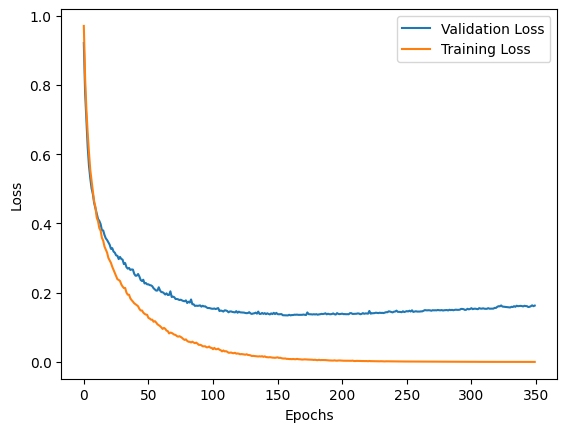

In [10]:
# plot the losses
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Save the model weights
torch.save(model.state_dict(), 'Brain_weights.pth')

In [12]:
# model = BrainClassifier()
# model.to(device)
# model.load_state_dict(torch.load('./Brain_weights.pth'))

In [13]:
x, y = next(iter(test_loader))
model.eval()
y_pred = model(x.to(device)).argmax(1)
# y --> label vere
# y_pred --> label modello

In [14]:
# compute the accuracy
correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model(img)
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.9279475982532751


In [15]:
model2 = BrainClassifierBis()
model2 = model2.to(device)
model2.eval()

correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model2(img.float().to(device))
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.19213973799126638


## Test with different learning rate

In [16]:
# Example instantiation and trainin
model = BrainClassifierBis()
tstart = time.time()

# increase the learning rate by 10
train_losses, val_losses = train(model, train_loader, val_loader, epochs=250, lr=0.000001, wd=1e-5)

tend = time.time()
print("Time elapsed: ", tend-tstart)

Epochs: 100%|███████| 250/250 [33:20<00:00,  8.00s/it, Training Loss=tensor(0.0002), Validation Loss=0.17]

Time elapsed:  2000.862561225891


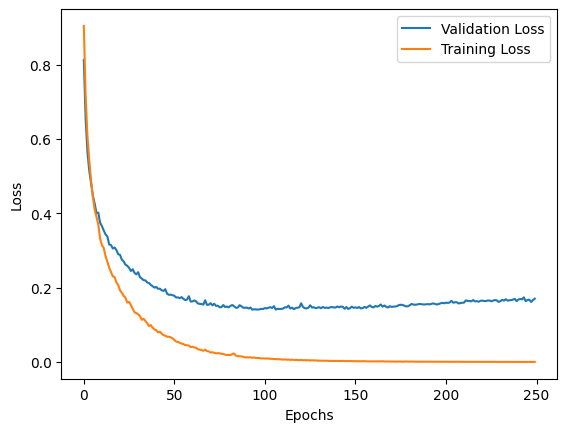

In [17]:
# plot the losses
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
x, y = next(iter(test_loader))
model.eval()
y_pred = model(x.to(device)).argmax(1)
# y --> label vere
# y_pred --> label modello# compute the accuracy
correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model(img)
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.9344978165938864


In [19]:
model2 = BrainClassifierBis()
model2 = model2.to(device)
model2.eval()

correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model2(img.float().to(device))
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.2554585152838428
